In [41]:
import sys
from collections import deque
import pytest
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import HTML
from IPython.display import display
import graphviz
import timeit
import pandas as pd

from utils import *

def convertToList(solu_tuple):
    solu_list = []
    for i in solu_tuple:
        solu_list.append(i)
    return solu_list
#plot NQueens
def plot_NQueens(solution):
    n = len(solution)
    board = np.array([2 * int((i + j) % 2) for j in range(n) for i in range(n)]).reshape((6, 6))
    im = Image.open('s_queen.png')
    height = im.size[1]
    im = np.array(im).astype(np.float64) / 255
    fig = plt.figure(figsize=(5, 5))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.1, hspace=0.1)
    ax = fig.add_subplot(111)
    ax.set_title('{}-Queens'.format(n))
    plt.imshow(board, interpolation='nearest')
    if isinstance(solution, dict):
        for (k, v) in solution.items():
            newax = fig.add_axes([0.064 + (v * 0.112), 0.062 + ((5 - k) * 0.112), 0.1, 0.1], zorder=2)
            newax.imshow(im)
            newax.axis('off')
    elif isinstance(solution, list):
        for (k, v) in enumerate(solution):
            rect = [0.064 + (v * 0.112), 0.062 + ((5 - k) * 0.112), 0.1, 0.1]
            newax = fig.add_axes(rect, zorder=2)
            newax.imshow(im)
            newax.axis('off')
    plt.tight_layout()
    plt.show()


class Problem:
    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2. If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self, state):
        """For optimization problems, each state has a value. Hill Climbing
        and related algorithms try to maximize this value."""
        raise NotImplementedError


# ______________________________________________________________________________

class Node:
    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. Note
    that if a state is arrived at by two paths, then there are two nodes with
    the same state. Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node. Other functions
    may add an f and h value; see best_first_graph_search and astar_search for
    an explanation of how the f and h values are handled. You will not need to
    subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        """[Figure 3.10]"""
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
        return next_node

    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    # We want for a queue of nodes in breadth_first_graph_search or
    # astar_search to have no duplicated states, so we treat nodes
    # with the same state as equal. [Problem: this may not be what you
    # want in other contexts.]

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        # We use the hash value of the state
        # stored in the node instead of the node
        # object itself to quickly search a node
        # with the same state in a Hash Table
        return hash(self.state)

# ______________________________________________________________________________


def backtrack_search(problem, all_solutions=None, all_nodes=None):
    if all_solutions is None:
        all_solutions = []

    if all_nodes is None:
        all_nodes = {}

    if problem.goal_test(problem.initial):
        all_solutions.append(problem.initial)
        all_nodes[problem.initial] = {
            "state": problem.initial,
            "parent": None,
            "action": None,
            "path_cost": 0,
            "depth": 0,
            "path": [problem.initial],
        }
        return all_nodes, all_solutions

    all_nodes[problem.initial] = {
        "state": problem.initial,
        "parent": None,
        "action": None,
        "path_cost": 0,
        "depth": 0,
        "path": [problem.initial],
    }

    for action in problem.actions(problem.initial):
        next_state = problem.result(problem.initial, action)

        if not problem.conflicted(next_state, action, next_state.index(action)):
            new_problem = NQueensProblem(problem.N)
            new_problem.initial = next_state  # Update the initial state
            all_nodes, all_solutions = backtrack_search(new_problem, all_solutions, all_nodes)
            all_nodes[problem.initial]["children"] = all_nodes.get(problem.initial, {}).get("children", []) + [next_state]

    return all_nodes, all_solutions



class NQueensProblem(Problem):
    """The problem of placing N queens on an NxN board with none attacking
    each other. A state is represented as an N-element array, where
    a value of r in the c-th entry means there is a queen at column c,
    row r, and a value of -1 means that the c-th column has not been
    filled in yet. We fill in columns left to right.
    >>> uniform_cost_search(problem, display=True)
    <Node (1, 3, 5, 0, 2, 4)>
    """

    def __init__(self, N):
        super().__init__(tuple([-1] * N))
        self.N = N

    def actions(self, state):
        """In the leftmost empty column, try all non-conflicting rows."""
        if state[-1] != -1:
            return []  # All columns filled; no successors
        else:
            col = state.index(-1)
            return [row for row in range(self.N)
                    if not self.conflicted(state, row, col)]

    def result(self, state, row):
        """Place the next queen at the given row."""
        col = state.index(-1)
        new = list(state[:])
        new[col] = row
        return tuple(new)

    def conflicted(self, state, row, col):
        """Would placing a queen at (row, col) conflict with anything?"""
        return any(self.conflict(row, col, state[c], c)
                   for c in range(col))

    def conflict(self, row1, col1, row2, col2):
        """Would putting two queens in (row1, col1) and (row2, col2) conflict?"""
        #print("would putting two queens in (row1, col1)"+str(row1)+str(col1)+" and (row2, col2) conflict?",)
        #Check Only same row and same column
        return (row1 == row2 or  # same row
                col1 == col2 or  # same column
                row1 - col1 == row2 - col2 or  # same \ diagonal
                row1 + col1 == row2 + col2
               )  # same / diagonal

    def goal_test(self, state):
        """Check if all columns filled, no conflicts."""
        if state[-1] == -1:
            return False
        return not any(self.conflicted(state, state[col], col)
                       for col in range(len(state)))

    def h(self, node):
        """Return number of conflicting queens for a given node"""
        num_conflicts = 0
        for (r1, c1) in enumerate(node.state):
            for (r2, c2) in enumerate(node.state):
                if (r1, c1) != (r2, c2):
                    num_conflicts += self.conflict(r1, c1, r2, c2)

        return num_conflicts

#_______________________________________________________________________________

# Code to compare searchers on various problems.


class InstrumentedProblem(Problem):
    """Delegates to a problem, and keeps statistics."""

    def __init__(self, problem):
        self.problem = problem
        self.succs = self.goal_tests = self.states = 0
        self.found = None

    def actions(self, state):
        self.succs += 1
        return self.problem.actions(state)

    def result(self, state, action):
        self.states += 1
        return self.problem.result(state, action)

    def goal_test(self, state):
        self.goal_tests += 1
        result = self.problem.goal_test(state)
        if result:
            self.found = state
        return result

    def path_cost(self, c, state1, action, state2):
        return self.problem.path_cost(c, state1, action, state2)

    def value(self, state):
        return self.problem.value(state)

    def __getattr__(self, attr):
        return getattr(self.problem, attr)

    def __repr__(self):
        #print("succs, goal_tests, states, str(self.found)[:4]", '<{:4d}/{:4d}/{:4d}/{}>'.format(self.succs, self.goal_tests,self.states, str(self.found)[:4]))
        return '<{:4d}/{:4d}/{:4d}/{}>'.format(self.succs, self.goal_tests,
                                               self.states, str(self.found))#str(self.found)[:4]
    
#___________________________________________________________________________________________________________________________________________________________________________    


def compare_searchers(problems, header,
                      searchers=[
                                 backtrack_search
                                 ]):
    def do(searcher, problem):
        p = InstrumentedProblem(problem)
        searcher(p)
        return p

    table = [[name(s)] + [do(s, p) for p in problems] for s in searchers]
    print("Total Number of Actions/  Total Number of goal tests/  Total Number of states/  Final Solution")
    print_table(table, header)


In [42]:
all_nodes, all_solutions = backtrack_search(NQueensProblem(6))

# Extract information for all nodes
nodes_information = {}
for node, node_data in all_nodes.items():
    nodes_information[node] = {
        "state": node_data["state"],
        "parent": node_data["parent"],
        "action": node_data["action"],
        "path_cost": node_data["path_cost"],
        "depth": node_data["depth"],
        "path": node_data["path"],
    }

print(nodes_information,len(nodes_information))

{(-1, -1, -1, -1, -1, -1): {'state': (-1, -1, -1, -1, -1, -1), 'parent': None, 'action': None, 'path_cost': 0, 'depth': 0, 'path': [(-1, -1, -1, -1, -1, -1)]}, (0, -1, -1, -1, -1, -1): {'state': (0, -1, -1, -1, -1, -1), 'parent': None, 'action': None, 'path_cost': 0, 'depth': 0, 'path': [(0, -1, -1, -1, -1, -1)]}, (0, 2, -1, -1, -1, -1): {'state': (0, 2, -1, -1, -1, -1), 'parent': None, 'action': None, 'path_cost': 0, 'depth': 0, 'path': [(0, 2, -1, -1, -1, -1)]}, (0, 2, 4, -1, -1, -1): {'state': (0, 2, 4, -1, -1, -1), 'parent': None, 'action': None, 'path_cost': 0, 'depth': 0, 'path': [(0, 2, 4, -1, -1, -1)]}, (0, 2, 4, 1, -1, -1): {'state': (0, 2, 4, 1, -1, -1), 'parent': None, 'action': None, 'path_cost': 0, 'depth': 0, 'path': [(0, 2, 4, 1, -1, -1)]}, (0, 2, 4, 1, 3, -1): {'state': (0, 2, 4, 1, 3, -1), 'parent': None, 'action': None, 'path_cost': 0, 'depth': 0, 'path': [(0, 2, 4, 1, 3, -1)]}, (0, 2, 5, -1, -1, -1): {'state': (0, 2, 5, -1, -1, -1), 'parent': None, 'action': None, 'p

In [45]:
n_queens=NQueensProblem(6)
def test_time_complexity():
    #breadth_first_graph_search(romania_ma)
    print("*********************************")
    print("    Time Complexity Analysis Report     ")
    print("*********************************")
    print("recursive_best_first_search: ",format(timeit.timeit("backtrack_search(n_queens)", setup="from __main__ import timeit, backtrack_search,n_queens",number=1)*1000,'.4g'),"millisec")
    
test_time_complexity()
 

*********************************
    Time Complexity Analysis Report     
*********************************
recursive_best_first_search:  5.082 millisec


In [46]:
all_nodes, all_solutions = backtrack_search(NQueensProblem(6))
all_solutions

[(1, 3, 5, 0, 2, 4),
 (2, 5, 1, 4, 0, 3),
 (3, 0, 4, 1, 5, 2),
 (4, 2, 0, 5, 3, 1)]

(1, 3, 5, 0, 2, 4)


C:\Users\msigl6595dk\AppData\Local\Temp\ipykernel_33504\2328728947.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


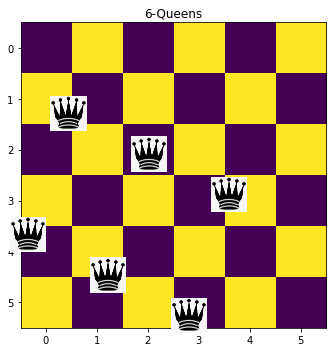

(2, 5, 1, 4, 0, 3)


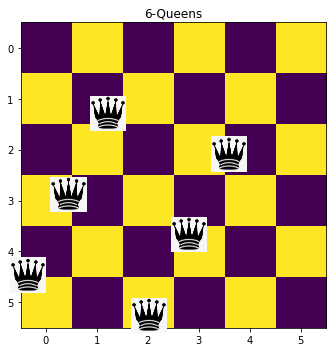

(3, 0, 4, 1, 5, 2)


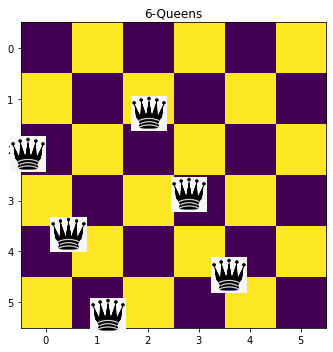

(4, 2, 0, 5, 3, 1)


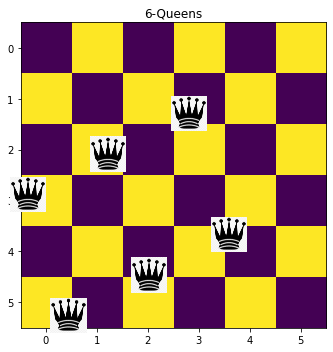

In [47]:
#Plot the solutions
for node in all_solutions:
    solu_list = convertToList(node)
    print(node)
    plot_NQueens(solu_list)

In [48]:
nodes     = pd.DataFrame(data=all_nodes)
nodes_transpose = nodes.T
nodes_transpose.to_excel('nodes___backtrack_search.xlsx', sheet_name='nodes')
nodes_transpose

state parent action path_cost depth  \
-1 -1 -1 -1 -1 -1  (-1, -1, -1, -1, -1, -1)   None   None         0     0   
 0 -1 -1 -1 -1 -1   (0, -1, -1, -1, -1, -1)   None   None         0     0   
    2 -1 -1 -1 -1    (0, 2, -1, -1, -1, -1)   None   None         0     0   
       4 -1 -1 -1     (0, 2, 4, -1, -1, -1)   None   None         0     0   
          1 -1 -1      (0, 2, 4, 1, -1, -1)   None   None         0     0   
...                                     ...    ...    ...       ...   ...   
 5  3  0 -1 -1 -1     (5, 3, 0, -1, -1, -1)   None   None         0     0   
          4 -1 -1      (5, 3, 0, 4, -1, -1)   None   None         0     0   
       1 -1 -1 -1     (5, 3, 1, -1, -1, -1)   None   None         0     0   
          4 -1 -1      (5, 3, 1, 4, -1, -1)   None   None         0     0   
             2 -1       (5, 3, 1, 4, 2, -1)   None   None         0     0   

                                         path  \
-1 -1 -1 -1 -1 -1  [(-1, -1, -1, -1, -1, -1)]   
 0 -1 -1 -1 -1 -1   [(0, -1, -1, -1, -1, -1)]   
    2 -1 -1 -1 -1    [(0, 2, -1, -1, -1, -1)]   
       4 -1 -1 -1     [(0, 2, 4, -1, -1, -1)]   
          1 -1 -1      [(0, 2, 4, 1, -1, -1)]   
...                                       ...   
 5  3  0 -1 -1 -1     [(5, 3, 0, -1, -1, -1)]   
          4 -1 -1      [(5, 3, 0, 4, -1, -1)]   
       1 -1 -1 -1     [(5, 3, 1, -1, -1, -1)]   
          4 -1 -1      [(5, 3, 1, 4, -1, -1)]   
             2 -1       [(5, 3, 1, 4, 2, -1)]   

                                                            children  
-1 -1 -1 -1 -1 -1  [(0, -1, -1, -1, -1, -1), (1, -1, -1, -1, -1, ...  
 0 -1 -1 -1 -1 -1  [(0, 2, -1, -1, -1, -1), (0, 3, -1, -1, -1, -1...  
    2 -1 -1 -1 -1     [(0, 2, 4, -1, -1, -1), (0, 2, 5, -1, -1, -1)]  
       4 -1 -1 -1                             [(0, 2, 4, 1, -1, -1)]  
          1 -1 -1                              [(0, 2, 4, 1, 3, -1)]  
...                                                              ...  
 5  3  0 -1 -1 -1                             [(5, 3, 0, 4, -1, -1)]  
          4 -1 -1                                                NaN  
       1 -1 -1 -1                             [(5, 3, 1, 4, -1, -1)]  
          4 -1 -1                              [(5, 3, 1, 4, 2, -1)]  
             2 -1                                                NaN  

[153 rows x 7 columns]